# CAP 781
# Evaluating Classification Models

## Alternative Metrics for Binary Classification

When one class occurs more frequent than the other one, this results in `imbalanced class` problem. In such a case, we would like to take a look at other metrics rather than accuracy since the higher accuracy rate may come from majority class rather than minority class as illusrated below. In each case below, accuracy is 90%.

![](images/accuracy.png)

If we don't care about majority class (e.g. a non-diabetes class) correct and we only care about identifying minority class (e.g. a diabetes class) correct, then the metrics `Precision` and `Recall` can be useful rather than accuracy.


## Confusion Matrix

Remember the lay-out of confusion matrix:

![](images/confusion2.png)


## Precision and Recall

The measures `Precision` and `Recall` are defined as:

\begin{align*}
\underset{\text{(positive predictive value)}}{\text{Precision}} & = \frac{\text{TP}}{\text{predicted positive}} = \frac{\text{TP}}{\text{TP} + \text{FP}}\\
\underset{\text{(sensitivity, true positive rate)}}{\text{Recall}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}}. 
\end{align*}

- `Precision`: Of the positive predictions the classifier made, how many were actually true positive labels? (Useful when we want to **limit the number of false positives**)
- `Recall`: Out of the all true positive labels, how many did the model identify? (Useful when we want to **avoid false negatives**)

## Trade-off between Precision and Recall

We can obtain a perfect recall if we predict all samples to belong to the positive class-there will be no false negative, and no true negatives either. However, predicting all samples as positive will result in many false positives, and therefore the precision will be very low. For that reason, there is a trade-off between optimizing recall and optimizing precision. 


## F1-Score

One way to summarize `Precision` and `Recall` in a single summary measure is `F1-Score` metric which is the geometric mean of recall and precision as follows:

$$
\text{F1-Score} = \frac{2}{\frac{1}{\text{Recall}} + \frac{1}{\text{Precision}}}.
$$

The best F1-score is 1.0 and the worst is 0.0. A disadvantage of F1-score is that it is harder to interpret.

The [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) fuction in scikit-learn summarizes all these metrics for us.

## Re-Visit Diabetes Dataset

Diabetes data set contains details of a hospital's patients and the target variable is a binary variable reflecting the fact: whether the patient has diabetes (Yes:1) or not (No:0).

In [82]:
#import the data set
import numpy as np
import pandas as pd

diabetes_df = pd.read_csv("datasets/Diabetes.csv")

In [83]:
#there are some inconsistent values in the data set. I removed patients whose bmi and glucose are both zero
diabetes_df = diabetes_df[(diabetes_df.bmi!=0) & (diabetes_df.glucose!=0)]

In [84]:
#from sklearn import set_config
#set_config(transform_output="pandas")  

#Prepare X and y
X = diabetes_df.drop(columns=["diabetes"]) #.values #lost column names, it requires values attributes
y = diabetes_df[["diabetes"]]

Let's split the data into two sets: trainbig and test sets and train a logistic classifier with `penalty=None` on the trainbig set and evaluate its performance on test set.

In [85]:
#first split the data as train and test. Use stratify so that the ratio of 0's to 1's in train data equals to that of in test data
from sklearn.model_selection import train_test_split

X_train_big, X_test, y_train_big, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1773, stratify=y)

In [86]:
#fit the logistic classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(StandardScaler(),LogisticRegression(penalty=None, max_iter=1000))  

lr_pipe.fit(X_train_big, y_train_big.diabetes)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty=None))])

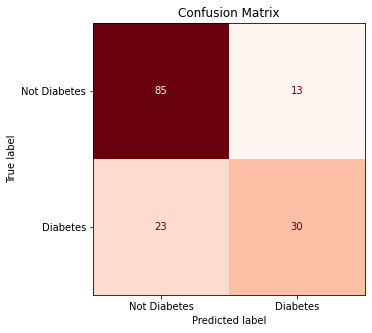

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(lr_pipe, 
                                           X_test, y_test, 
                                           display_labels=["Not Diabetes","Diabetes"], 
                                           cmap="Reds",
                                           colorbar=False)
                                           
cm.ax_.set_title("Confusion Matrix");

In [88]:
print("Accuracy on test data: %.4f %%" % lr_pipe.score(X_test, y_test.diabetes))

Accuracy on test data: 0.7616 %


Our classifier is able to correctly identify 115 cases out of 150 in unseen set. However, since the size of the non-diabetes class (majority class) is larger than the size of diabetes class (minority class), the classifier focuses on getting non-diabetes class right, and not the smaller diabetes class. Then, it would be better to focus on `Recall`, `Precision`, and `F1-Score` scores of diabetes class (minority class in our case).

In [89]:
from sklearn.metrics import classification_report

print(
    classification_report(
    y_test, lr_pipe.predict(X_test), target_names=["Non-Diabetes", "Diabetes"]
    )
)

              precision    recall  f1-score   support

Non-Diabetes       0.79      0.87      0.83        98
    Diabetes       0.70      0.57      0.62        53

    accuracy                           0.76       151
   macro avg       0.74      0.72      0.73       151
weighted avg       0.76      0.76      0.75       151



- Of all the patients the model predicted are diabetic, how many are actually diabetic?
   - Precision: 30/(13+30)=0.70. 
   - 70% percent of the ones who are predicted diabetic are actually diabetic.
- Of all the patients that are actually diabetic, how many did the model identify?
   - Recall: 30/(30+23)=0.57.
   - **The model predicts 57% of diabetic patients correctly**. **Note that accuracy was 76.16**.
- The classification report also includes averages for these metrics, including a weighted average that allows for the imbalance in the number of cases of each class. 
- `Macro Avg Recall` = (0.87 + 0.57)/2 = 0.72.
- `Weighted Avg Recall` =  0.87 * (98/151) + 0.57 * (53/151)=0.76. 

[Accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), [Precision_Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score), [Recall_Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score), [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) are also
implemented in [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) submodule of scikit-learn.

## Cross validation with different metrics

Note that we can pass different classification evaluation metrics with `scoring` argument of [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) and [gridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [90]:
#the metrics above are also implemented in sklearn.metrics
from sklearn.metrics import get_scorer_names

#get_scorer_names()

## Advanced Classification Metrics

When we are making predictions and computing `Recall`, `Precision`, and `F1-Score` scores, we are actually thresholding the outputs of `predict_proba` and `decision_function` at 0.5 and 0, respectively. 

In our diabetes example, having a higher recall on diabetes class is more important. This means we are willing to risk more false positives in exchange for more true positives (which will increase recall). We want **more points to be classified as diabetes class, so need to decrease the threshold**.

Let’s lower the threshold to 0.23. In other words, predict the patients as “diabetes” if `predict_proba` > 0.1. (We are now more likely to label patients as diabetes --> Increase in TP and FP).

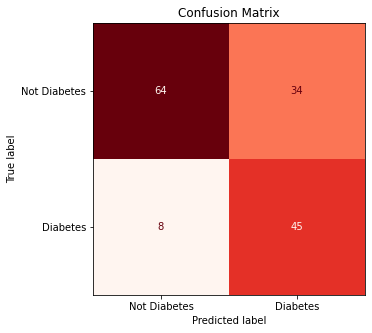

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_lower_threshold = lr_pipe.predict_proba(X_test)[:, 1] > 0.23

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lower_threshold,
                            display_labels=["Not Diabetes","Diabetes"], 
                            cmap="Reds",
                            colorbar=False)
                                           
cm.ax_.set_title("Confusion Matrix");

In [92]:
from sklearn.metrics import classification_report

print(
    classification_report(
    y_test, y_pred_lower_threshold, target_names=["Non-Diabetes", "Diabetes"]
    )
)

              precision    recall  f1-score   support

Non-Diabetes       0.89      0.65      0.75        98
    Diabetes       0.57      0.85      0.68        53

    accuracy                           0.72       151
   macro avg       0.73      0.75      0.72       151
weighted avg       0.78      0.72      0.73       151



As expected, the recall of diabetes class went up (now 0.85), and the precision went down (now 0.57).

**Then, the question is: How to choose optimum threshold?**

## Sensitivity and Specificity

![](images/confusion2.png)

`Sensitivity` and `Specificity` gives us the `accuracy on each class` separately and are defined as follows: 
\begin{align*}
\underset{\text{(recall, true positive rate)}}{\text{sensitivity}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}} \quad \text{and} \\
\underset{\text{(true negative rate)}}{\text{specificity}} & = \frac{\text{TN}}{\text{negative class}} = \frac{\text{TN}}{\text{TN} + \text{FP}}.  
\end{align*}

Note that in binary classification, `recall of the positive class` is also known as `sensitivity` or  `true positive rate (TPR)` and `recall of the negative class` is `specificity` or `true negative rate (FNR)`.

## Receiver Operating Characteristic (ROC)

In binary classification, the `Receiver Operating Characteristic` (ROC) curve plots the `true positive rate (TPR)` and the `false positive rate (FPR)` as we vary the threshold for labeling a positive example.

\begin{align*}
\text{TPR} = \underset{\text{(recall, sensitivity)}}{\text{true positive rate}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}} \quad \text{and} \\
\text{FPR} = 1-\underset{\text{(true negative rate)}}{\text{specificity}} & = 1 - \frac{\text{TN}}{\text{negative class}} = \frac{\text{FP}}{\text{TN} + \text{FP}}. \\
\end{align*}

Suppose we want to improve TPR (recall, sensitivity) for diabetes class on the diabetes data set.

We first compute the probability $Pr(y=1\vert \mathbf{x})$ for each input $\mathbf{x}$. For any threshold $t>0$, we label $\mathbf{x}$ as diabetes class if $Pr(y=1\vert \mathbf{x})>t$. 

* Small $t$ result in a high TPR (we identify all positives) and high FPR (many are false).
* High $t$ result in a low TPR (we identify few positives) and low FPR (we only label the most confident inputs).

The ROC curve can be computed using the [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function in scikit-learn. Below is the the ROC curve measuring the TPR and FPR as $t$ varies.

In [93]:
#calculate fpr, tpr
from sklearn.metrics import roc_curve

#y_true:True binary labels. y_score=Target scores,
fpr, tpr, thresholds = roc_curve(y_true = y_test,  y_score = lr_pipe.predict_proba(X_test)[:, 1]) #lr_pipe.decision_function(X_test) 

In [94]:
results = {"Threshold": thresholds,
           "TPR": tpr,
           "FPR": fpr
          }
pd.DataFrame(results)

,Threshold,TPR,FPR
0,1.984712,0.000000,0.000000
1,0.984712,0.018868,0.000000
2,0.951569,0.056604,0.000000
3,0.931715,0.056604,0.010204
4,0.812380,0.207547,0.010204
5,0.799728,0.207547,0.020408
6,0.789035,0.245283,0.020408
7,0.780433,0.245283,0.030612
8,0.765916,0.283019,0.030612
9,0.765167,0.283019,0.040816


In [95]:
#let's find optimum threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_idx

44

In [96]:
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.23179414720360447

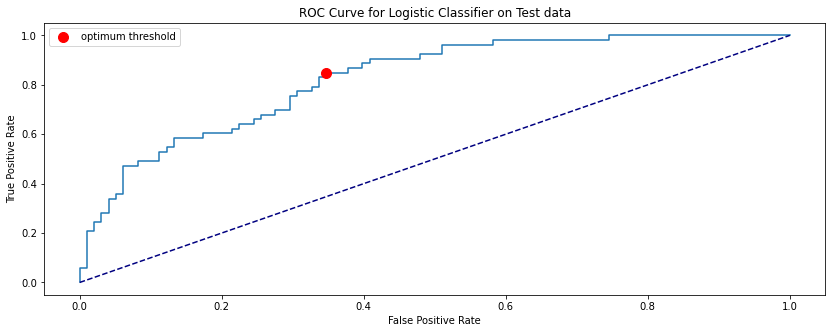

In [97]:
#visualize ROC curve
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 5]

from sklearn.metrics import RocCurveDisplay

#visualize roc curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr) 
display.plot()

#add a straight line with 45 degree
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#add the optimum threshold
plt.plot(fpr[optimal_idx],tpr[optimal_idx], "or",  markersize=10, label="optimum threshold")
plt.title("ROC Curve for Logistic Classifier on Test data")
plt.legend(loc="best")
plt.show();

We highlight the following properties of the ROC curve:
* In the bottom left corner,  TPR = FPR = 0. We predict only negatives.
* In the top right corner, TPR = FPR = 1. We predict only positives. 
* The ideal classifier is in the top left: TPR = 1, FPR = 0.
* The blue diagonal corresponds to randomly guessing "positive" with $p = \text{TPR}$.
* The ROC curve lies between ideal and random.

Let's apply this optimum threshold to evaluate the model's recall on the test data. So, by changing the threshold value, we obtained an improvement on the model's recall performance on the test data.

In [98]:
from sklearn.metrics import classification_report

y_test_pred = lr_pipe.predict_proba(X_test)[:, 1] > optimal_threshold

print(
    classification_report(
    y_test, y_test_pred, target_names=["Non-Diabetes", "Diabetes"] #with optimized threshold
    )
) 

              precision    recall  f1-score   support

Non-Diabetes       0.88      0.65      0.75        98
    Diabetes       0.56      0.83      0.67        53

    accuracy                           0.72       151
   macro avg       0.72      0.74      0.71       151
weighted avg       0.77      0.72      0.72       151



## Area Under the Curve

We can use the `area under the curve` (AUC) as a **single measure** of a classifier performance.
* The ideal classifier (ROC curve reaches top left corner) has an AUC-ROC of 1.0.
* A random classifier (diagonal dashed line) has an AUC-ROC of 0.5.

We may compute the AUC of the above ROC curve as follows with [auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) function.

In [99]:
from sklearn.metrics import auc
print('AUC-ROC: %.4f' % auc(fpr, tpr))

AUC-ROC: 0.8235


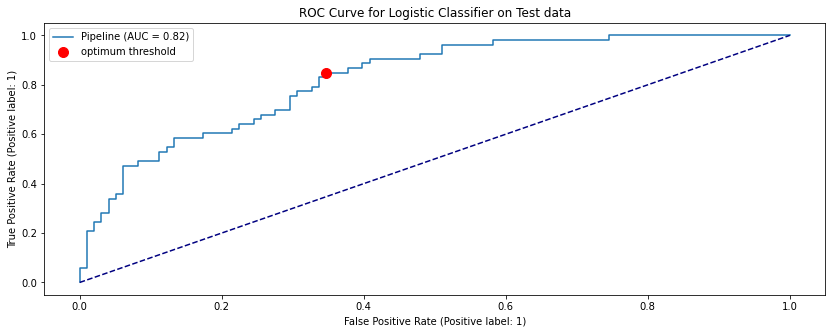

In [100]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lr_pipe, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot(fpr[optimal_idx],tpr[optimal_idx], "or",  markersize=10, label="optimum threshold")
plt.title("ROC Curve for Logistic Classifier on Test data")
plt.legend(loc="best")
plt.show();

## Classifier Selection with AUC metric

AUC shows how a classifier is able to classify positive classes as true and false. The higher AUC, the better classification is. For that reason, for classification problems with imbalanced classes, using AUC for model selection is often much more meaningful than using accuracy.
Let's now carry out a `GridSearchCV` with `scoring='roc_auc'` to select a model among the candidate classifiers.

In [101]:
#take a look at the metrics available and find roc_auc
from sklearn.metrics import get_scorer_names

#get_scorer_names()

In [102]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#The choice of the algorithm depends on the penalty chosen.
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))

#Define parameter range
param_grid = [{'logisticregression__penalty' : ['l1', 'l2'],
               'logisticregression__C' : np.logspace(-4, 4, 20)
               }
              ]  
               
#The folds are made by preserving the percentage of samples for each class.
kcv_index = StratifiedKFold(n_splits=5, shuffle=True, random_state=1773) 

gs = GridSearchCV(estimator = lr_pipe, param_grid = param_grid, scoring='roc_auc',   cv = kcv_index)                                                      

In [103]:
gs.fit(X_train_big, y_train_big.diabetes)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1773, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid=[{'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'logisticregression__penalty': ['l1', 'l2']}],
             scoring='roc_auc')

In [104]:
print("Optimum Model:", gs.best_params_)
print("CV AUC: %.2f %%" % (gs.best_score_*100))

Optimum Model: {'logisticregression__C': 0.615848211066026, 'logisticregression__penalty': 'l1'}
CV AUC: 83.95 %


Among the candidate models, we found out the one which gives highest cross-validated AUC on validation data. It is the logistic regression with L1 norm where C=0.6.

In [105]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.615848211066026, penalty='l1',
                                    solver='liblinear'))])

Let's apply best model on test data to evaluate its AUC.

In [106]:
#Evaluate final performance of best logistic classifier on test
print("AUC on test data: %.2f" % gs.score(X_test, y_test))

AUC on test data: 0.82


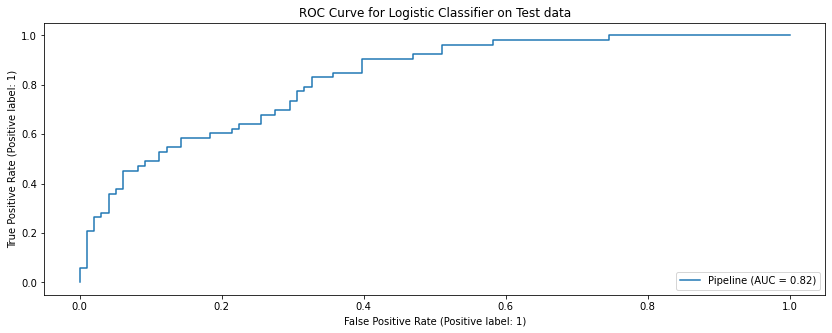

In [107]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs.best_estimator_, X_test, y_test)
plt.title("ROC Curve for Logistic Classifier on Test data")
plt.show();

## References

- James, G., Witten, D., Hastie, T., Tibshirani, R., James, G., Witten, D., and Tibshirani, R. (2021). Statistical learning. An introduction to statistical learning: with applications in R. https://www.statlearning.com/.
- Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: A guide for data scientists. O'Reilly Media, Inc.
- https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/tree/main/notebooks
- https://ubc-cs.github.io/cpsc330/lectures/09_classification-metrics.html
- https://www.scikit-yb.org/en/latest/api/classifier/index.html
- https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

In [108]:
import session_info
session_info.show()